# Import Libraries

In [1]:
# !pip install evojax
# !pip install flax
# !pip install evosax
# !pip install pyDOE

In [2]:
import os
import numpy as np
import jax
import shutil
import jax.numpy as jnp
import logging
import time
import matplotlib.pyplot as plt
from jax import random, grad, vmap, hessian, jacfwd
from evojax import Trainer
from evojax.task.base import TaskState
from evojax.task.base import VectorizedTask
from evojax.policy.base import PolicyNetwork
from evojax.policy.base import PolicyState
from evojax.util import create_logger
from evojax.util import get_params_format_fn
from flax.struct import dataclass
from typing import Tuple
from flax import linen as nn
from jax.nn.initializers import xavier_uniform
from evojax.sim_mgr import SimManager
from flax.core.frozen_dict import unfreeze, freeze
from scipy import dot, exp, log, sqrt, floor, ones, randn, zeros_like, Inf, argmax, argmin, eye, outer, zeros
from scipy import array, power, diag, cos, sin, pi

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Directory to save logs and models

In [4]:
# Let's create a directory to save logs and models.
log_dir = 'loggerfiles'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('EvoJax for PINNs')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


# Functions

In [5]:
@dataclass
# Contains the train input and its labels
class State(TaskState):
    obs: jnp.ndarray
    labels: jnp.ndarray
# function to generate analytical solution
def f_x(t):
    return x0 + t*u0

def f_y(t):
    return y0 + t*v0 - 1./2*g*t**2

def f_t():
    return (vel0*sin(a0*pi/180) + sqrt((vel0*sin(a0*pi/180))**2 + 2*g*y0)) / g

# free fall
def terminal_vel():
    vinf = sqrt(2*m*g / (d*Cd*A))
    return vinf

def f_yfree(t, vinf):
    y_free = y0 - vinf**2/g*log(np.cosh(g*t/vinf))
    return y_free

In [6]:
# specify planet to change g, d & a_T
# planet = {'earth': (9.8, 1.2, 2), 'mars': (3.7, 0, 4.5), 'moon': (1.6, 0, 10)}
planet = {'earth': (9.8, 0, 2), 'mars': (3.7, 0, 5.5), 'moon': (1.6, 0, 8)}
g, d, a_T = planet['mars']

# parameter related to flying ball (constant)
m = 0.6
r = 0.12
Cd = 0.54
A = pi*r**2

# initial condition @(x, y) position
x0, y0 = 0, 2
# initial condition @velocity
vel0 = 10         

# angle of projectile
a0 = 80

# initial velocity
u0 = vel0 * cos(a0*pi/180)
v0 = vel0 * sin(a0*pi/180)

# time domain: 0 - t_T
t_T = a_T    # let it fly..

/tmp/ipykernel_3857233/2850935375.py:21: DeprecationWarning: scipy.cos is deprecated and will be removed in SciPy 2.0.0, use numpy.cos instead
  u0 = vel0 * cos(a0*pi/180)
/tmp/ipykernel_3857233/2850935375.py:22: DeprecationWarning: scipy.sin is deprecated and will be removed in SciPy 2.0.0, use numpy.sin instead
  v0 = vel0 * sin(a0*pi/180)


In [7]:
# def genBoundary_t_0(batch_size=1):
#     return np.zeros(batch_size).reshape(-1, 1)

# def genCollocation_T(batch_size=8):
#     #ALPHA, BETA = 1, 1
#     #return np.random.beta(a=ALPHA, b=BETA, size=batch_size).reshape(-1, 1) *t_T
#     return lhs(1, samples=batch_size) *t_T   # use LHS sampling..

In [8]:
n_pde= 10000
n_ic= 1
t = jnp.linspace(0, t_T, n_pde).reshape(-1, 1)

# batch_X = np.vstack([genBoundary_t_0(n_ic), genCollocation_T(n_pde)])
# batch_X = np.hstack([batch_X, np.zeros(len(batch_X)).reshape(-1, 1)])
# batch_Y = np.empty((len(batch_X), 1))
# shuffle
# perm = np.random.permutation(len(batch_X))

In [9]:
# Loss Function will be used as the fitness  (f=-L)
def loss(prediction, input, target):
  # essentially the new prediction here
    t = input[:,0:1].reshape(-1,1)
    x, y, x_t, y_t, x_tt, y_tt = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4], prediction[:,4:5], prediction[:,5:6]


    # ground truth
    x_true = f_x(t)
    y_true = f_y(t)  
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)

    # initial conditions (which define the problem)
    ic_1 = jnp.sum(jnp.square((x_true-x)*_ic))/jnp.sum(_ic)
    ic_2 = jnp.sum(jnp.square((y_true-y)*_ic))/jnp.sum(_ic)

    ic_3 = jnp.sum(jnp.square((x_t-u0)*_ic))/jnp.sum(_ic)
    ic_4 = jnp.sum(jnp.square((y_t-v0)*_ic))/jnp.sum(_ic)

    # sum up all initial conditions
    ic_mse = ic_1 + ic_2 + ic_3 + ic_4

    # consider drag effect
    V = jnp.sqrt( (x_t)**2 + (y_t)**2 )
    C = 0.5*d*Cd*A/m
    R = C*V

    # PDE (physics laws):
    pde_x = x_tt + R*x_t
    pde_y = y_tt + R*y_t + g
    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde_x = pde_x*_pde
    pde_y = pde_y*_pde        
    pde_residuals_x = jnp.sum(jnp.square(pde_x))/jnp.sum(_pde)
    pde_residuals_y = jnp.sum(jnp.square(pde_y))/jnp.sum(_pde)
    pde_mse = pde_residuals_x + pde_residuals_y

    loss = pde_mse + ic_mse
    return loss

# Accuracy should not be used in this case, change to mean square error
def mse(prediction, target):
    x, y  = prediction[:,0:1], prediction[:,1:2]
    x_true, y_true  = target[:,0:1], target[:,1:2]
    mse_x = jnp.mean(jnp.square(x-x_true))
    mse_y = jnp.mean(jnp.square(y-y_true))
    mean_square_error = mse_x + mse_y
    return mean_square_error

# Task

In [10]:
class Projectile(VectorizedTask):
    """PDE-NN for 2D projectile equation.
    We model the regression as a one-step task, i.e., 
    `Projectile.reset` returns a batch of data to the agent, the agent outputs
    predictions, `Projectile.step` returns the reward loss) and
    terminates the rollout.
    """

    def __init__(self, batch_size, test):

        self.max_steps = 1

        # These are similar to OpenAI Gym environment's
        # observation_space and action_space.
        # They are helpful for initializing the policy networks.
        # Input shape is 1
        self.obs_shape = tuple([1, ])
        # Output shape is 2
        self.act_shape = tuple([2, ])

        # PDE Data
        data_pde = t.reshape(-1,1)
        # samples, features = data_pde.shape
        x = f_x(data_pde)
        y = f_y(data_pde)
        labels_pde = jnp.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])


        def reset_fn(key):
            batch_data, batch_labels = data_pde, labels_pde
            # if test:
            #     # In the test mode, we want to test on the entire test set.
            #     batch_data, batch_labels = data_pde, labels_pde
            # else:
            #     # In the training mode, we only sample a batch of training data.
            #     batch_data, batch_labels = sample_batch(
            #         key, data_pde, labels_pde, data_bc, labels_bc, batch_size)
            return State(obs=batch_data, labels=batch_labels)
        
        # We use jax.vmap for auto-vectorization.
        self._reset_fn = jax.jit(jax.vmap(reset_fn))
        
        # step_fn needs to be changed
        def step_fn(state, action):
            if test:
                # In the test mode, we report the mean square error
                "change to training loss"
                # reward = loss(action, state.obs, state.labels)
                reward = mse(action, state.labels)
            else:
                # In the training mode, we return the negative loss as the
                # fitness. 
                # the action (prediction) will include u, u_x and u_xx
                reward = -loss(action, state.obs, state.labels)
            # This is an one-step task, so that last return value (the `done`
            # flag) is one.
            
            return state, reward, jnp.ones(())

        # We use jax.vmap for auto-vectorization.
        self._step_fn = jax.jit(jax.vmap(step_fn))
    # Returns a batch of data to the agent, the agent outputs predictions
    def reset(self, key):
        return self._reset_fn(key)
    # Returns the fitness loss
    def step(self, state, action):
        return self._step_fn(state, action)

In [11]:
seed = 0
batch_size = 498
train_task = Projectile(batch_size=batch_size, test=False)
test_task = Projectile(batch_size=batch_size, test=True)

# Policy

In [12]:
n_nodes = 8
class PINNs(nn.Module):
  """PINNs"""
  def setup(self):
    # hidden layers
    self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                   nn.tanh,
                   nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh]
    # split layers
    self.splitx = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, use_bias=False)]
    self.splity = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                   nn.tanh,
                   nn.Dense(1, use_bias=False)]


  @nn.compact
  def __call__(self, inputs):
      # split the two variables, probably just by slicing
      t= inputs#[:,0:1]
      
      def get_xy(t):
        for i, lyr in enumerate(self.layers):
          t = lyr(t)
        # split layers
        hidden_x = self.splitx[0](t)
        hidden_x = self.splitx[1](hidden_x)
        hidden_y = self.splity[0](t)
        hidden_y = self.splity[1](hidden_y)
        # output layers
        x = self.splitx[2](hidden_x)
        y = self.splity[2](hidden_y)
        return x, y

      x, y = get_xy(t)

      # deriviatives needed to obtain are x_t, y_t, x_tt, y_tt
      def get_xy_t(get_xy, t):
        x_t, y_t = jacfwd(get_xy)(t)
        return x_t, y_t
      xy_t_vmap = vmap(get_xy_t, in_axes=(None, 0))
      x_t, y_t = xy_t_vmap(get_xy, t)
      x_t = x_t.reshape(-1,1)
      y_t = y_t.reshape(-1,1)
      def get_xy_tt(get_xy, t):
        x_tt, y_tt = hessian(get_xy)(t)
        return x_tt, y_tt
      xy_tt_vmap = vmap(get_xy_tt, in_axes=(None, 0))
      x_tt, y_tt = xy_tt_vmap(get_xy, t)
      x_tt = x_tt.reshape(-1,1)
      y_tt = y_tt.reshape(-1,1)
      action = jnp.hstack([x, y, x_t, y_t, x_tt, y_tt])   
      return action


In [13]:
# model = PINNs()
# params = model.init(random.PRNGKey(0), jnp.zeros([1,1]))
# """Return a function that formats the parameters into a correct format."""
# num_params, format_params_fn = get_params_format_fn(params)
# num_params

In [14]:
class PINNsPolicy(PolicyNetwork):
    """A physics informmed neural neural network for the Projectile task."""

    def __init__(self, logger: logging.Logger = None):
        if logger is None:
            self._logger = create_logger('PINNsPolicy')
        else:
            self._logger = logger

        model = PINNs()
        key1, key2 = random.split(random.PRNGKey(seed))
        a = random.normal(key1, [1,1]) # Dummy input
        params = model.init(key2, a) # Initialization call
        """Return a function that formats the parameters into a correct format."""
        self.num_params, format_params_fn = get_params_format_fn(params)
        self._logger.info(
            'PINNsPolicy.num_params = {}'.format(self.num_params))
        self._format_params_fn = jax.vmap(format_params_fn)
        self._forward_fn = jax.vmap(model.apply)

    def get_actions(self,
                    t_states: TaskState,
                    params: jnp.ndarray,
                    p_states: PolicyState) -> Tuple[jnp.ndarray, PolicyState]:
        params = self._format_params_fn(params)
        return self._forward_fn(params, t_states.obs), p_states
policy = PINNsPolicy(logger=logger)

# Solvers

In [15]:
from evojax.algo import CMA_ES_JAX
popn = 80
solver = CMA_ES_JAX(
                pop_size=popn,
                param_size=policy.num_params,
                init_stdev=0.001,
                seed=seed,
                logger=logger)

# Training

In [16]:
max_iters = 40000 #50000//popn
num_tests = 1

sim_mgr = SimManager(n_repeats=1,
			test_n_repeats=1,
			pop_size=popn,      
			n_evaluations= num_tests,
			policy_net= policy,
			train_vec_task=train_task,
			valid_vec_task=test_task,
			seed=seed)

    
loss_ls = []
t_training = []
# best_ls = []
# t_fitness = 0
# start_time = time.perf_counter()
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    start = time.process_time()
    # Training.
    params = solver.ask()
    # This is where fitness is calculated, want to get the time
#     start = time.time()
    scores, _ = sim_mgr.eval_params(params=params, test=False)
#     end = time.time()
#     t_fitness = t_fitness + (end-start)
    
    # Updates the weights through the solver
    solver.tell(fitness=scores)
    # This is the average loss of all the population of parameters
    score_avg_loss = np.mean(np.array(scores, copy=False, subok=True))
    best_params = solver.best_params
#     if (train_iters < 10) | ((train_iters < 100) & (train_iters%10 == 0)) | ((train_iters < 1000) & (train_iters%100 == 0)) | ((train_iters < 10000) & (train_iters%100 == 0)) | ((train_iters < 300000) & (train_iters%1000 == 0)):
    end = time.process_time()
    t_training.append(end-start)
    loss_ls.append(-1*score_avg_loss)
    # update
    runtime += (end-start)
    train_iters += 1


In [17]:
training_ls = np.cumsum(t_training)

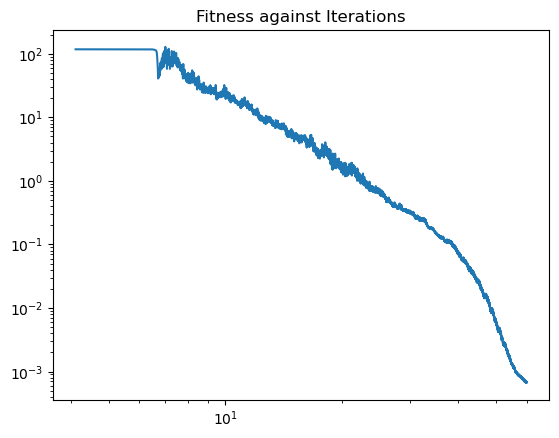

In [18]:
plt.plot(training_ls, loss_ls)
plt.xscale('log');plt.yscale('log');
# plt.xlim(800,1000)
# plt.ylim(-1e6,0)
plt.title('Fitness against Iterations')
plt.show()

In [19]:
import pandas as pd

df = pd.DataFrame({'Training Time': training_ls, 'Loss': loss_ls})
#df.to_csv('projectile_cma_%d.csv'%(seed), index=False)
df

,Training Time,Loss
0,4.106972,117.690002
1,5.954842,117.690002
2,5.964258,117.689987
3,5.973466,117.689987
4,5.982645,117.689980
...,...,...
6288,59.966585,0.000694
6289,59.975285,0.000690
6290,59.983959,0.000673
6291,59.992579,0.000688


In [20]:
this_dict = policy._format_params_fn(best_params[None, :])
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
  # print(value1)
  for key2, value2 in value1.items():
    # print(value2)
    for key3, value3 in value2.items():
      new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [21]:
# PDE Data
data_pde = t.reshape(-1,1)
# samples, features = data_pde.shape
labels_pde_x = f_x(data_pde)
labels_pde_y = f_y(data_pde)
# PINN
hello = PINNs()
prediction = hello.apply(new_dict, data_pde)
x, y = prediction[:,0:1], prediction[:,1:2]

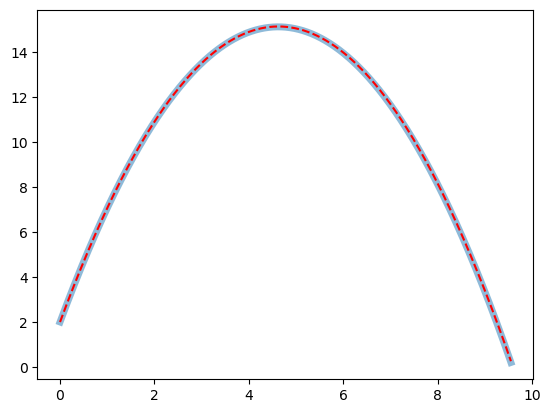

In [22]:
plt.plot(labels_pde_x, labels_pde_y, linewidth=5, alpha=.5);
plt.plot(x, y, linestyle='--', c='red');

In [23]:
np.mean((np.hstack([labels_pde_x, labels_pde_y]) - np.hstack([x, y]))**2)

0.00039579283

In [24]:
np.save('projectile_cma_60s', (x, y, labels_pde_x, labels_pde_y))